# Hands-on Weather forecast and Climate data
Example notebook for GEO4902

This tutorial is significantly based on [Getting your hands-on Climate data](https://nordicesmhub.github.io/climate-data-tutorial/).

## What is numerical weather prediction?
According to the [Glossary of Meteorology](https://glossary.ametsoc.org/wiki/Numerical_forecasting), _numerical forecasting_ is defined as
~~~
(Also called mathematical forecasting, dynamical forecasting, physical forecasting, numerical weather prediction.) The integration of the governing equations of hydrodynamics by numerical methods subject to specified initial conditions.

Numerical approximations are fundamental to almost all dynamical weather prediction schemes since the complexity and nonlinearity of the hydrodynamic equations do not allow exact solutions of the continuous equations.
See numerical integration, numerical simulation.
~~~

## What is reanalysis?
According to the [Glossary of Meteorology](https://glossary.ametsoc.org/wiki/Climate_prediction), _reanalysis_ is defined as 

~~~  
Same as analysis, except for two important practical differences.

First, it is not done in real time, and second, the background field is made by an NWP model that does not change over the entire period of the reanalysis. A serious problem with climate change studies made from standard analyses results from frequent changes in the model used to generate the background field. These changes (including changes in resolution and orography) lead to discontinuities in a time series of real-time analyses. A reanalysis yields complete, global gridded data that are as temporally homogeneous as possible. Reanalysis data include many derived fields (heating, soil moisture over land, etc.) for which direct observations are nearly absent.
~~~ 

## What is climate prediction?
According to the [Glossary of Meteorology](https://glossary.ametsoc.org/wiki/Climate_prediction), _climate prediction_ is defined as 

~~~  
The prediction of various aspects of the climate of a region during some future period of time.

Climate predictions are generally in the form of probabilities of anomalies of climate variables (e.g., temperature, precipitation), with lead times up to several seasons (
see climate anomaly). The term "climate projection" rather than "climate prediction" is now commonly used for longer- range predictions that have a higher degree of uncertainty and a lesser degree of specificity. For example, this term is often used for "predictions" of climate change that depend on uncertain consequences of anthropogenic influences such as land use and the burning of fossil fuels.
~~~

 



In [1]:
# Import packages
from datetime import datetime
import xarray as xr
xr.set_options(display_style='html')
import intake
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xesmf as xe


import cartopy.crs as ccrs
import cartopy as cy
from cmcrameri import cm


In [2]:
# # define a plot style
# plt.style.use('ggplot')
# sns.set_context('paper')
# sns.set(font = 'Serif', font_scale = 1, )
# sns.set_style("whitegrid",
#                   {'font.family':'serif', #'font.serif':'Helvetica'
#                    'grid.linestyle': '--'           },
#                    )

In [3]:
### Create dask cluster to work parallel in large datasets

from dask.distributed import Client
client = Client(n_workers=2, 
                threads_per_worker=2, 
                memory_limit='2GB',
                processes=False)
client
chunks={'time' : 10,}
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://129.240.48.123:8787/status,
Dashboard: http://129.240.48.123:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: False
Comm: inproc://129.240.48.123/48640/1,Workers: 2
Dashboard: http://129.240.48.123:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: inproc://129.240.48.123/48640/5,Total threads: 2
Dashboard: http://129.240.48.123:45165/status,Memory: 1.86 GiB
Nanny: None,


## What is the weather like in Oslo?
The script guides you to access and plot a single point-forecast of the 2-meter temperature, humidity, and wind forecast.

Open the latest weather forecast from the Norwegian forecast system (MEPS).
- We recomend to use `xarray`, to keep track of your coordinates and the metadata in your data! (E.g. numpy doesn't do this)
- This is why the NetCDF format is so popular -- it keeps track of these things and is extremely easy to load

In [4]:
# # datetime object containing current date and time
# # needed if used latest 
# now = datetime.now()
# # dd/mm/YY H:M:S
# date = now.strftime("%Y%m%d")
# month = now.strftime("%m")
# time = now.strftime('%H')
# print("date and time =", date, time)

# ini_time = '00'

In [5]:
#  Open the netCDF file containing the latest MEPS forecast.
# thredds = 'https://thredds.met.no/thredds/dodsC/mepslatest/meps_det_2_5km_{date}T{ini_time}Z.ncml'.format(date = date, ini_time = ini_time)
thredds = 'https://thredds.met.no/thredds/dodsC/mepslatest/meps_lagged_6_h_latest_2_5km_latest.nc'
ds = xr.open_dataset(thredds)

In [6]:
# check how the dataset looks like
# ds

In this case, we are interested in the 2-m temperature variable contained within that xarray Dataset:

In [7]:
ds['air_temperature_2m']

<xarray.DataArray 'air_temperature_2m' (time: 62, height0: 1,
                                        ensemble_member: 30, y: 1069, x: 949)>
[1886934660 values with dtype=float32]
Coordinates:
  * time             (time) datetime64[ns] 2022-09-14T04:00:00 ... 2022-09-16...
  * ensemble_member  (ensemble_member) int16 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
  * height0          (height0) float32 2.0
  * x                (x) float32 -1.06e+06 -1.058e+06 ... 1.307e+06 1.31e+06
  * y                (y) float32 -1.333e+06 -1.33e+06 ... 1.335e+06 1.337e+06
    longitude        (y, x) float64 ...
    latitude         (y, x) float64 ...
Attributes:
    long_name:      Screen level temperature (T2M)
    standard_name:  air_temperature
    units:          K
    grid_mapping:   projection_lambert
    _ChunkSizes:    [  1   1  10 357 317]

Check the attributes of the 2-m temperature. Can be useful info here!

In [8]:
ds['air_temperature_2m'].attrs

{'long_name': 'Screen level temperature (T2M)',
 'standard_name': 'air_temperature',
 'units': 'K',
 'grid_mapping': 'projection_lambert',
 '_ChunkSizes': array([  1,   1,  10, 357, 317], dtype=int32)}

We see that the 2-m temperature is in Kelvin. Transform 2-m temperature into $^{o}$ C. And assign the new attributes to your dataset.

This is nice to do when you are plotting. `xarray` is looking for `units`, `standard_name`, and `long_name` when plotting.

In [9]:
t2air = ds['air_temperature_2m'].sel(ensemble_member=slice(None,10)) - 273.15
t2air = t2air.assign_attrs({'units': 'C'})
t2air = t2air.assign_attrs({'description': '2-m Temperature in C'})

2022-09-14 09:29:21,542 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.46 GiB -- Worker memory limit: 1.86 GiB
2022-09-14 09:29:21,544 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.46 GiB -- Worker memory limit: 1.86 GiB
2022-09-14 09:29:21,755 - distributed.worker_memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 1.62 GiB -- Worker memory limit: 1.86 GiB
2022-09-14 09:29:21,756 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory lea

: 

: 

Let us now select a grid point close to the meteorological station at Blindern. 

**Oslo - Blindern**
- Station number (id): SN18700
- Height above mean sea level: 94 m
- Latitude: 59.9423º N
- Longitude: 10.72º E
- Operating period: 01.01.1931 - now
- WMO number: 1492
- Information taken from <https://seklima.met.no/stations/> a service by Met.no. 

> **_NOTE:_**  AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work


In [ ]:
# We define a function to find the closest grid point to the station selected
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    y, x = np.where(c == np.min(c))
    x=int(x)
    y=int(y)
   
    return (x,y)

In [ ]:
# find the x and y coordinates of Blindern station
lat = 59.9423
lon = 10.72
Blindern_x, Blindern_y = findindex(ds.latitude, ds.longitude, lat, lon)

In [ ]:
# check if we selected the correct coordinates for Blindern
if ds.latitude.isel(y = Blindern_y, x = Blindern_x).round(decimals=1) == np.round_(lat, decimals=1) and \
    ds.longitude.isel(y = Blindern_y, x = Blindern_x).round(decimals=1) == np.round_(lon, decimals =1):
    print('You selected the closest point to your station! Lat: {}, Lon: {}'.format(
        ds.latitude.isel(y = Blindern_y, x = Blindern_x).round(decimals=2).values,
        ds.longitude.isel(y = Blindern_y, x = Blindern_x).round(decimals=2).values))

You selected the closest point to your station! Lat: 59.95, Lon: 10.74


Plot the point forecast of the 2-meter temperature, humidity, and wind forecast

In [12]:
# 2-m temperature
T2_Blindern = ds['air_temperature_2m'].isel(y = Blindern_y, x = Blindern_x, height1 = 0)

# 2-m relative humidity
ds['relative_humidity_2m'] = ds['relative_humidity_2m'].assign_attrs({'units': 'kg/kg'})
ds['relative_humidity_2m'] = ds['relative_humidity_2m'].assign_attrs({'description': '2-m relative humidity in kg/kg'})
RH2_Blindern = ds['relative_humidity_2m'].isel(y = Blindern_y, x = Blindern_x, height1 = 0)

# 10-m wind speed
WS_Blindern = ds['wind_speed'].isel(y = Blindern_y, x = Blindern_x, height7 = 0)

# 10-m wind direction
WD_Blindern = ds['wind_direction'].isel(y = Blindern_y, x = Blindern_x, height7 = 0)

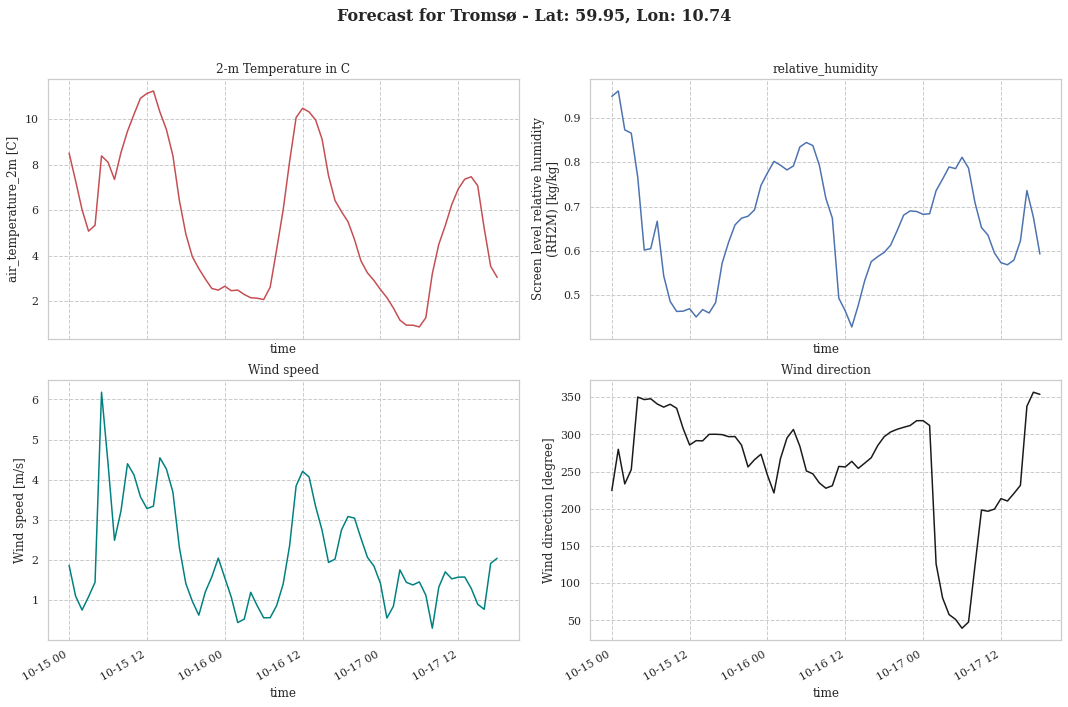

In [15]:
fig, axsm = plt.subplots(2,2, figsize = [15, 10], sharex=True, )

axs = axsm.flatten()

# 2-m temperature
T2_Blindern.plot(ax = axs[0], x='time', add_legend=True#color = 'r')
axs[0].set_title(T2_Blindern.attrs['description'])

# 2-m relative humidity
RH2_Blindern.plot(ax = axs[1], color = 'b')
axs[1].set_title(RH2_Blindern.attrs['standard_name'])

# 10-m wind speed
WS_Blindern.plot(ax = axs[2], color = 'teal')
axs[2].set_title(WS_Blindern.attrs['long_name'])

# 10-m wind direcation
WD_Blindern.plot(ax = axs[3], color = 'k')
axs[3].set_title(WD_Blindern.attrs['long_name'])



plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Forecast for Tromsø - Lat: {}, Lon: {}'.format(
        ds.latitude.isel(y = Blindern_y, x = Blindern_x).round(decimals=2).values,
        ds.longitude.isel(y = Blindern_y, x = Blindern_x).round(decimals=2).values),fontsize=16, fontweight="bold");


## What is the climate in Oslo between 1985 - 2014?
To get some information about the (past 30 years) climate in Oslo, we will first look at monthly averages. For this we use Reanalysis data from ERA5.


In [59]:
path = '/uio/kant/geo-metos-u1/franzihe/Documents/Python/GEO4902/visualization_python/data/2t_Amon_ERA5_1985_2014_Norway.nc'
ds_era = xr.open_dataset(path)


In [62]:
# Transform 2-m temperature into degC and assign attributes
ds_era['t2m'] = ds_era['t2m'] - 273.15
ds_era['t2m'] = ds_era['t2m'].assign_attrs({'units': 'C'})
ds_era['t2m'] = ds_era['t2m'].assign_attrs({'long_name': '2-m temperature'})


In [91]:
# create a mean for each month over the 30-year data 
_t2_era_mean = ds_era['t2m'].groupby('time.month').mean('time', keep_attrs = True)


Plot 2-m temperature, averaged over the 30 years per month from ERA5 on spatial map. Select the same month as your weather forecast, MEPS

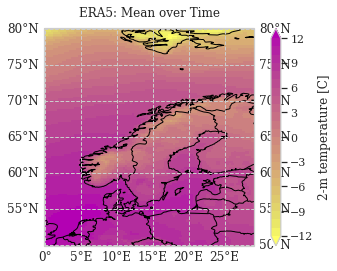

In [101]:
f,ax = plt.subplots(subplot_kw={'projection' : ccrs.PlateCarree()})

_t2_era_mean.sel(month = int(month)).plot.pcolormesh(
    cmap     = cm.buda_r,
    robust   = True,
    ax       = ax,
    transform = cy.crs.PlateCarree(),
    levels   = range(-12,13,1)
)

ax.set_title('ERA5: Mean over Time')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.add_feature(cy.feature.BORDERS);
gl.top_labels = False;



Create some statistics for the 30 years and all month, such as mean, standard deviation, and percentiles. Plot the statistics on a spatial map.

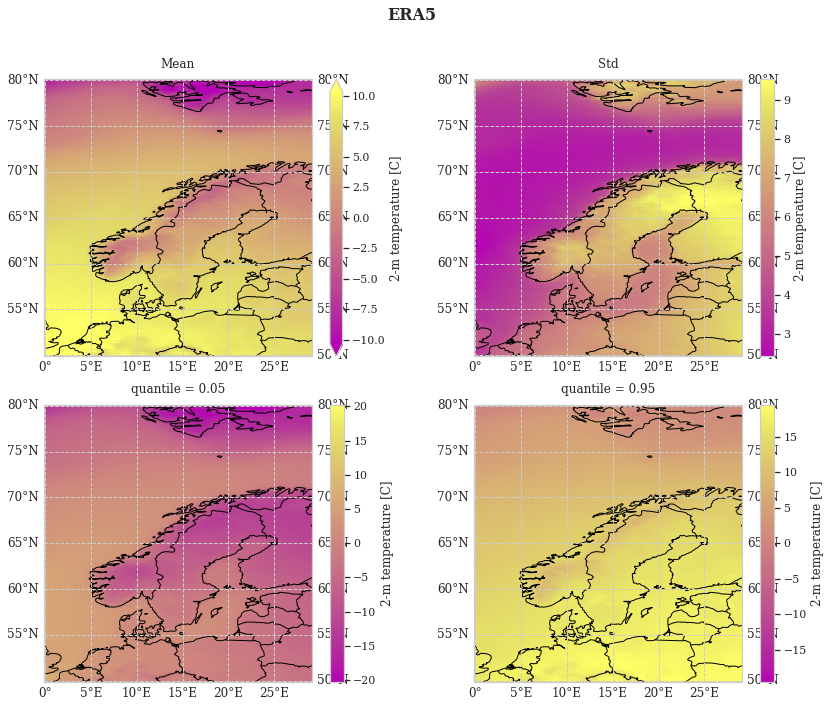

In [112]:
# The mean per month is already defined as _t2_era_mean

fig, axsm = plt.subplots(2,2, 
                         figsize=[12,10], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
axs = axsm.flatten()

# plot the mean
_t2_era_mean.mean('month', keep_attrs=True).plot(ax=axs[0], transform=ccrs.PlateCarree(), robust=True, cmap = cm.buda)
axs[0].set_title('Mean')

# plot the standard deviation
_t2_era_mean.std('month', keep_attrs=True).plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap = cm.buda)
axs[1].set_title('Std')

# plot the quantiles
_t2_era_mean.quantile(0.05,'month', keep_attrs=True).plot(ax=axs[2], transform=ccrs.PlateCarree(), cmap = cm.buda)
_t2_era_mean.quantile(0.95,'month', keep_attrs=True).plot(ax=axs[3], transform=ccrs.PlateCarree(), cmap = cm.buda)

for ax in axs:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False;

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('ERA5',fontsize=16, fontweight="bold");

Select the closest grid point to Oslo Blindern and plot the 2-m temperature. From ERA5 plot the 30-yr yearly-mean temperature. Make another plot which shows temperature forecast of MEPS latest and the 30-yr climate average of the month of MEPS latest.

To select the closest grid point in a regular grid you can use [Nearest neighbor lookups](http://xarray.pydata.org/en/stable/user-guide/indexing.html#nearest-neighbor-lookups). The label based selection methods sel() support method and tolerance keyword argument.



In [123]:
# The mean per month is already defined as _t2_era_mean, select closest grid point
_t2_era_Blindern = _t2_era_mean.sel(latitude = lat, longitude = lon, method="nearest")

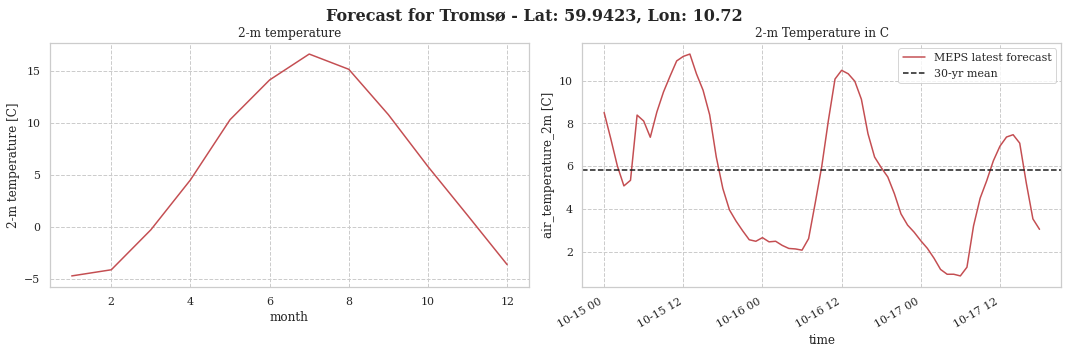

In [154]:
# Plot
fig, axsm = plt.subplots(1,2, figsize = [15, 5], )

axs = axsm.flatten()
# 2-m temperature ERA5
_t2_era_Blindern.plot(ax = axs[0], color = 'r')
axs[0].set_title(_t2_era_Blindern.attrs['long_name'])


# 2-m temperature MEPS
T2_Blindern.plot(ax = axs[1], color = 'r', label = 'MEPS latest forecast')
axs[1].set_title(T2_Blindern.attrs['description'])

# specifying horizontal
plt.axhline(y = _t2_era_Blindern.sel(month = int(month)), color = 'k', linestyle = '--', label = '30-yr mean')
axs[1].legend(loc = 'upper right')

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Forecast for Tromsø - Lat: {}, Lon: {}'.format(lat, lon),fontsize=16, fontweight="bold");

# CMIP& monthly data on single levels
Retrieve near surface temperature using Pangeo cataloge

Open CMIP6 online catalog


In [163]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,517247
dcpp_init_year,60


Search correspnding data

In [164]:
list_models = ['NorESM2-MM', ]

variable_id=[
            #  'pr', 
             'tas',
             ]
cat = col.search(source_id=list_models, experiment_id=['historical'], variable_id=variable_id[0], member_id=['r1i1p1f1'])
cat.df



,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-MM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historica...,NaN,20191108
1,CMIP,NCC,NorESM2-MM,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historica...,NaN,20191108


Create dictionary from the list of datasets we found

- This step may take several minutes so be patient!

In [165]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [166]:
list(dset_dict.keys())

['CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.day.gn']

In [239]:
ds_cmip = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
# Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
ds_cmip = ds_cmip.assign_coords(lon=(((ds_cmip.lon + 180) % 360) - 180)).sortby('lon').sortby('time')

Plot 30-yr seasonal mean for 2-m temperature in degC from CMIP 6 - NorESM. 

In [240]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

ds_cmip = ds_cmip.sel(time = ds_cmip.time.dt.year.isin(year_range)).squeeze() 
ds_cmip['tas'] = ds_cmip['tas'] - 273
ds_cmip['tas'] = ds_cmip['tas'].assign_attrs({'units': 'C'})
ds_cmip['tas'] = ds_cmip['tas'].assign_attrs({'long_name': 'Near-Surface Air Temperature'})


# seasonal mean
t2_cmip_sm = t2_cmip.groupby('time.season').mean('time',  keep_attrs = True)
t2_cmip_sm = t2_cmip_sm.assign_attrs({'units': 'C'})
t2_cmip_sm = t2_cmip_sm.assign_attrs({'long_name': 'Near-Surface Air Temperature'})



/tmp/ipykernel_269614/465295799.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


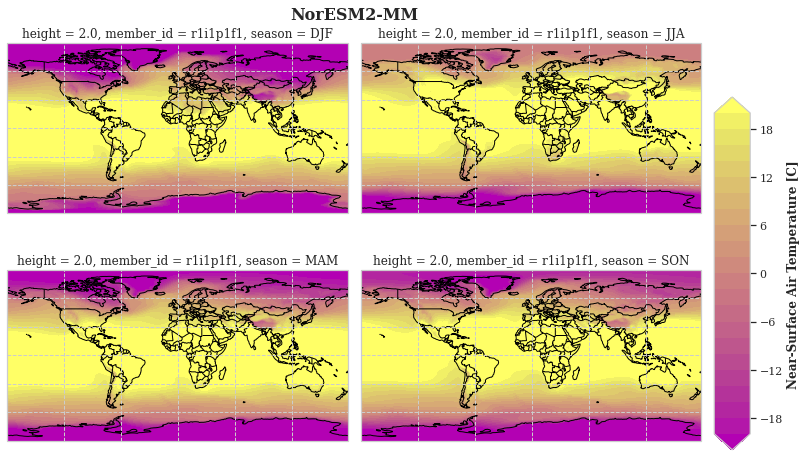

In [241]:
fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle(list(dset_dict.keys())[0].split('.')[2], fontsize=16, fontweight="bold")
axs = axsm.flatten()

for ax, i in zip(axs, t2_cmip_sm.season):
    im = t2_cmip_sm.sel(season = i).plot.contourf(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        cmap = cm.buda, 
                                        vmin = -20, vmax = 20,
                                        levels = range(-20, 22, 2),
                                        add_colorbar = False,
                                        robust=True)

    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1., 0.1, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", )
cb.set_label(label= '{} [{}]'.format(t2_cmip_sm.attrs['long_name'], t2_cmip_sm.attrs['units']), weight='bold')

plt.tight_layout()
fig.subplots_adjust(top=1)

Regrid the ERA5 data to the same resolutio as the NorESM grid. 
- ERA5 has a 0.25deg resolution
- NorESM-MM has a resolution of ~100km



Regrid the ERA data.
We use the [universal regridder for geospatial](https://xesmf.readthedocs.io/en/latest/) data `xesmf`. We regrid between rectilinear grids.

The input grid will be the ERA5 grid, while NorESM-MM will be used as output grid.

In [242]:
# But first, select area of Norway. The lat and lon grid will be used in the regridding process.
ds_out = ds_cmip.sel(lat= slice(ds_era.latitude.min(), ds_era.latitude.max()),
                      lon= slice(ds_era.longitude.min(), ds_era.longitude.max())).squeeze() 

In [243]:
# perform regridding
regridder = xe.Regridder(ds_era, ds_out, 'bilinear')
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_121x117_32x24.nc 
Reuse pre-computed weights? False 
Input grid shape:           (121, 117) 
Output grid shape:          (32, 24) 
Periodic in longitude?      False

The regridder says it can transform data from shape `(121, 117)` to shape `(32, 24)`.

Regrid the `DataArray` is straightforward:

In [246]:
# Apply regridder to data
# the entire dataset can be processed at once
ds_era_regrid = regridder(ds_era)

Plot the difference between the 2-m temperatura of ERA5 and CMIP6 as seasonal averages.

In [257]:
# seasonal mean
t2m_era_regrid = ds_era_regrid['t2m'].groupby('time.season').mean('time', keep_attrs = True)

t2m_cmip_regrid = ds_out['tas'].groupby('time.season').mean('time', keep_attrs = True)

# calculate difference between ERA5 and CMIP6 model
_diff = t2m_era_regrid - t2m_cmip_regrid

/tmp/ipykernel_269614/2282680849.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


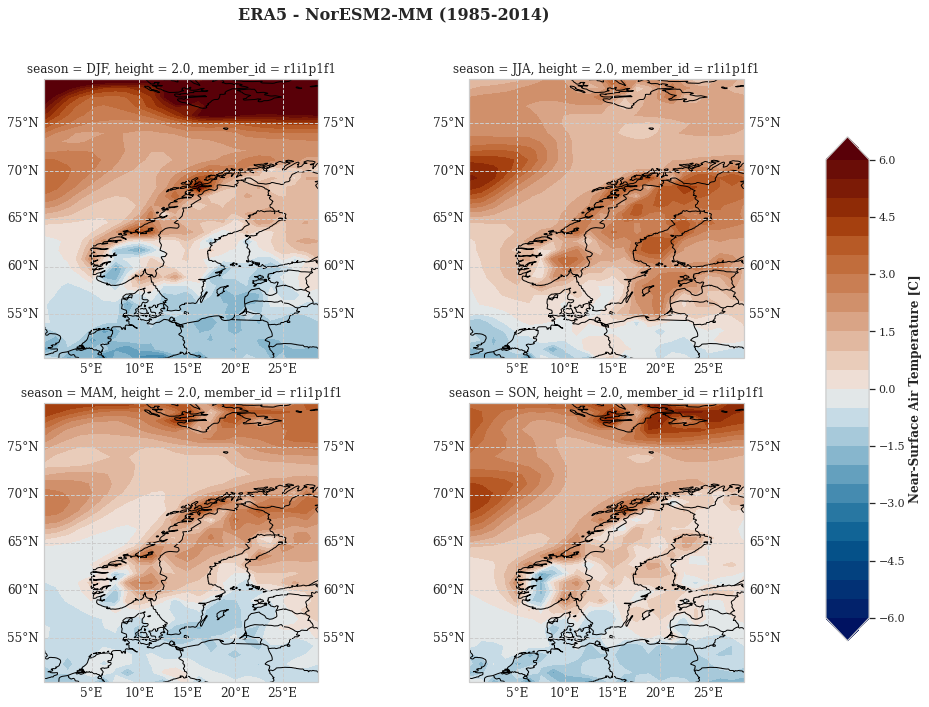

In [270]:
fig, axsm = plt.subplots(2,2, 
                         figsize=[12,10], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle('ERA5 - NorESM2-MM (1985-2014)', fontsize=16, fontweight="bold")
axs = axsm.flatten()

for ax, i in zip(axs, t2_cmip_sm.season):
    im = _diff.sel(season = i).plot.contourf(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        cmap = cm.vik, 
                                        vmin = -6, vmax = 6,
                                        levels = np.arange(-6, 6.5, 0.5),
                                        add_colorbar = False,
                                        extend = 'both',
                                        robust=True)

    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False;

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1., 0.1, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", )
cb.set_label(label= '{} [{}]'.format(t2_cmip_sm.attrs['long_name'], t2_cmip_sm.attrs['units']), weight='bold')

plt.tight_layout()
fig.subplots_adjust(top=0.88)